In [2370]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output as clr
import os
import numpy as np

In [2371]:
device = "cpu"
if(torch.cuda.is_available()):
    deivce = "gpu"

torch.autograd.set_detect_anomaly(True)

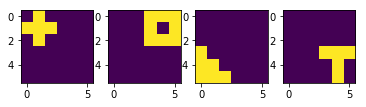

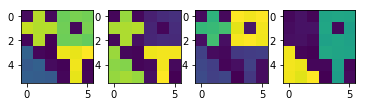

In [3966]:
# Synthetic Data Genration

'''Basis Generation'''
k1 = np.zeros((6,6))
k1[0:3,1] = 1.0
k1[1,0:3] = 1.0

k2 = np.zeros((6,6))
k2[0:3,-3:] = 1.0
k2[1,-2] = 0

k3 = np.zeros((6,6))
k3[-3:,0:3] = 1.0
k3[-3:-1,2] = 0.0
k3[-3,1:2] = 0.0

k4 = np.zeros((6,6))
k4[-3:,-2] = 1.0
k4[-3,-3:] = 1.0

fig, ax = plt.subplots(1,4)

ax[0].imshow(k1)
ax[1].imshow(k2)
ax[2].imshow(k3)
ax[3].imshow(k4)


'''Data Generation'''

train_size = 3000
test_size = 500

train_weights = np.random.rand(train_size, 4)
train_data = np.dot(train_weights,np.array([k1.reshape(-1,1),k2.reshape(-1,1),k3.reshape(-1,1),k4.reshape(-1,1)]).reshape(4,-1))
train_data += np.random.normal(0,0.01, size = train_data.shape)

test_weights = np.random.rand(test_size, 4)
test_data = np.dot(test_weights,np.array([k1.reshape(-1,1),k2.reshape(-1,1),k3.reshape(-1,1),k4.reshape(-1,1)]).reshape(4,-1))
test_data += np.random.normal(0,0.01, size = test_data.shape)


fig, ax = plt.subplots(1,4)

ax[0].imshow(train_data[0].reshape(6,6))
ax[1].imshow(train_data[300].reshape(6,6))
ax[2].imshow(test_data[0].reshape(6,6))
ax[3].imshow(test_data[300].reshape(6,6))

In [3967]:
BATCH_SIZE = 100

trainloader = torch.utils.data.DataLoader(train_data.reshape(-1,1,6,6), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
print("Done !")

Done !


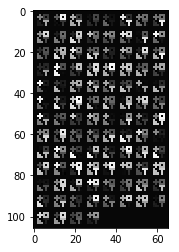

In [3968]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images[0])

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

dataiter = iter(trainloader)
images = dataiter.next()
show_images(images)

In [3969]:
class GLM_NP(nn.Module):
    def __init__(self, latent_variable_dim, alpha = 1.0, rholr = 10e-12):
        super(GLM_NP, self).__init__()
        
        ### Global Params
        self.eps1 = torch.tensor(10e-6).float()
        self.eps2 = torch.tensor(10e-4).float()
        
        # V : Stick breaking : Beta {kumaraswamy}
        self.aeys = nn.Parameter(torch.rand(1,latent_variable_dim) + 2)
        self.bees = nn.Parameter(torch.rand(1,latent_variable_dim) + 2)
        self.unif_sampler = torch.distributions.uniform.Uniform(self.eps1, 1-self.eps1)
        
        # IBP prior
        self.alpha = alpha
        self.euler_constant = np.e
        
        # Z : Bernoulli
        self.phi = nn.Parameter(torch.randn((36 + 1),latent_variable_dim))
        
        # Gumbel Softmax params
        self.temperature = 10
        self.gumbel_sampler = torch.distributions.gumbel.Gumbel(0,1)
        
        # Basis
        self.A = nn.Parameter(torch.randn(latent_variable_dim, 36))
        
        ### Russian Roulette part
        self.rhos = torch.zeros(latent_variable_dim + 1,1) + 0.5
        self.rholr = rholr
        
    
    def reparameterize_gumbel_kumaraswamy(self, inter_z, p):
        '''Proper Sampling is required with masking'''
        
        N, K = inter_z.shape
        sample_size = 20
        
        U = self.unif_sampler.sample([N,K,sample_size])
        G0 = self.gumbel_sampler.sample([N,K,sample_size])
        G1 = self.gumbel_sampler.sample([N,K,sample_size])
        
#         logV = (-(U.log()/self.bees.view(1,K)).exp()).log1p()/self.aeys.view(1,K)
        V = (1-U.pow(1/self.aeys[:,:K].view(-1,K,1))).pow(1/self.bees[:,:K].view(-1,K,1))
        
        pi = torch.zeros_like(V)+1
        for i in range(K):
            for j in range(i+1):
                pi[:,i,:] *= V[:,j,:]
        
        rand_num = torch.rand_like(pi)
        rand_logit = (rand_num/(1-rand_num)).log()
        
        
        logit_pi = ((pi + self.eps1)/(1-pi + self.eps1)).log()
        alpha = (logit_pi + inter_z.view(N,K,1) + rand_logit).sigmoid().pow(0.98)
        
        z1 = ((alpha + self.eps1).log() + G1)/self.temperature
        z0 = ((1 - alpha + self.eps1).log() + G0)/self.temperature
        
        maxz = torch.max(z0,z1)
        z1 = z1 - maxz
        z0 = z0 - maxz
        
        logsumexp = (z1.exp() + z0.exp()).log()
        
        z1 = z1 - logsumexp + self.eps1
        z0 = z0 - logsumexp + self.eps1
        
        y = z1.exp()/(z0.exp() + z1.exp())
        
#         if(p != 0):
#             mask = torch.rand_like(y)*0
#             mask[:,:p] = 1
#         else:
#             mask = 1
        
#         y = y*mask
        
        return y, alpha, pi
        
    def forward(self, input, k):
        x = input.view(-1, 36)
        N, D = x.shape
        
#         if(k != 0 and False):
#             mask2 = torch.rand_like(self.phi)*0
#             mask2[:,:k] = 1
#         else:
#             mask2 = 1
            
        
        inter_z = self.phi # 785 x K
        x_cat = torch.cat((input.view(N,36), torch.ones(N).view(N,-1)), 1).view(N,36+1) # N x 785
        inter_z = torch.mm(x_cat, inter_z[:,:k]) # N x K
        
        z, gi, pi = self.reparameterize_gumbel_kumaraswamy(inter_z, k) # N x K
#         print(z.shape)
#         assert 1== 2
        x = self.decode(z.mean(dim=-1).view(N,k), k)
        
        return x, z, gi, pi

    
    def decode(self, z, k):
#         if(k != 0):
#             mask = torch.rand_like(self.A)*0
#             mask[:,:k] = 1
#         else:
#             mask = 1
        x = F.linear(z, self.A.transpose(0,1)[:,:k])#.sigmoid()
        
        return x
    
    
    def add_k_node(self, k):
        # Add k latent features ...
        if(k == 0):
            return 
        with torch.no_grad():
            self.aeys = nn.Parameter(torch.cat((self.aeys, torch.rand(1,k) + 2), 1))
            self.bees = nn.Parameter(torch.cat((self.bees, torch.rand(1,k) + 2), 1))
            
            self.phi = nn.Parameter(torch.cat((self.phi, torch.randn((36 + 1),k)), 1))
            self.A = nn.Parameter(torch.cat((self.A, torch.randn(k, 36)), 0))
            
            
            self.rhos = torch.cat((self.rhos, torch.zeros(k,1) + 0.5), 0)
    
    def del_k_node(self, k):
        # Retain k Latent Features ...
        if(k == 0 or k == self.get_current_K()):
            return
        with torch.no_grad():
            c_K = self.get_current_K()
            
            self.aeys = nn.Parameter(list(torch.split(self.aeys, c_K - k , 1))[0])
            self.bees = nn.Parameter(list(torch.split(self.bees, c_K - k , 1))[0])
            
            self.phi = nn.Parameter(list(torch.split(self.phi, c_K - k , 1))[0])
            self.A = nn.Parameter(list(torch.split(self.A, c_K - k , 0))[0])
            
            self.rhos = list(torch.split(self.rhos, c_K - k + 1, 0))[0]
                             
    def get_current_K(self):
        return self.aeys.shape[1]
    
    def constraint_proj(self):
        with torch.no_grad():
            self.aeys[self.aeys < 0.001] = 0.001
            self.bees[self.bees < 0.001] = 0.001
            self.rhos[self.rhos < 10e-6] = 10e-6
            self.rhos[self.rhos > 1 - 10e-6] = 1 - 10e-6

In [3970]:
def get_kth_trunc_loss(model, images, K = 0):
    
    recon_image, z, gi, pi = model(images, K)
    softplus = nn.Softplus()
    eps = model.eps1
    if(K == 0):
        K = model.aeys.shape[1]
    
    z = z[:,:K]
    pi = pi[:,:K]
    gi = gi[:,:K]
    
    
    KL_kuma = ((model.aeys - model.alpha)/(model.aeys))*(-model.euler_constant -torch.digamma(model.bees) - 1/model.bees)
    KL_kuma += (model.aeys.log() + model.bees.log())
    KL_kuma -= (model.bees - 1)/(model.bees)
    
#     print(KL_kuma)
    KL_kuma = torch.sum(KL_kuma[:,:K])\
    
    logit_pi = (pi+eps).log() - (1-pi+eps).log()
    logit_x  =  (z+eps).log() - (1 -z+eps).log()
    logit_gi = (gi+eps).log() - (1-gi+eps).log()
    
    

    exp_term_p = logit_pi - logit_x*(model.temperature+1-1)
    exp_term_q = logit_gi - logit_x*(model.temperature+1-1)
    log_tau = torch.log(torch.tensor(model.temperature, requires_grad = False))
    
    
#     print(exp_term_p[0], exp_term_q[0])
    
    
    tau = model.temperature
    
#     log_pz = log_tau + exp_term_p - 2.0*((pi/(z+eps).pow(tau) + (1-pi)/((1-z+eps).pow(tau))).log())
#     log_qz = log_tau + exp_term_q - 2.0*((gi/(z+eps).pow(tau) + (1-gi)/((1-z+eps).pow(tau))).log())
    


    
    
    log_pz = log_tau + exp_term_p - 2.0*softplus(exp_term_p)
    log_qz = log_tau + exp_term_q - 2.0*softplus(exp_term_q)

#     print(log_qz[0,:], log_pz[0,:])


    
#     Kt = torch.argmax(torch.arange(K)*(z[:,:K].sum(dim = 0) > 0).long()) + 1
    
    mask_K = torch.zeros_like(log_pz)
    mask_K[:,:K] = 1
    
#     mask_Kt = torch.zeros_like(log_qz)
#     mask_Kt[:,:K] = 1
    
    log_pz = (mask_K*log_pz)[log_pz == log_pz]
    log_qz = (mask_K*log_qz)[log_qz == log_qz]

    
    KL_gumb = (log_qz - log_pz)
    
    KL_gumb = KL_gumb[KL_gumb == KL_gumb]
#     print(KL_gumb)
    KL_gumb = torch.sum(KL_gumb)
    
    
    ''' Add some more KL terms from K||B ,  '''
    
    Lik = -0.5*(recon_image - images.view(-1,36)).pow(2)
#     print(Lik[0])
    Lik = torch.sum(Lik) - float(36*0.5*np.log(2*np.pi))
#     Lik = -F.binary_cross_entropy(recon_image, images.view(-1, 36), reduction='sum')
    
    KL_l = KL_kuma + KL_gumb
#     print(KL_kuma, KL_gumb)
    print(Lik, KL_kuma, KL_gumb)
#     
#     assert(1==2)
    return -Lik  + KL_l

In [3971]:
def retain_k_nodes(model , new_K = 0):
    
    current_K = model.get_current_K()
    if(current_K < new_K):
        model.add_k_node(new_K - current_K)
    elif(current_K > new_K):
        model.del_k_node(current_K - new_K)
    else:
        pass
    
    optimizer = torch.optim.Adam(model.parameters(), 0.1)
    
    return optimizer

In [3972]:
def rrs_loss(model, images, curr_K):
    
    l = torch.zeros(curr_K,1)
    for i in range(curr_K):
        l[i,:] = get_kth_trunc_loss(model, images, K = i+1)
        
    
    one_minus_rho = (1 - model.rhos[1:curr_K+2]).view(curr_K,1)
    
    return l, one_minus_rho

In [3973]:
def train_step(model, images, add_max = 5, sample = False):
    
    """ sample a trucation level and then do the same"""
    
    curr_K = model.get_current_K()
    model.rhos[0] = 1
    
    optimizer = retain_k_nodes(model , new_K = curr_K + add_max)
    
    
    
    if(sample):
        optimizer = retain_k_nodes(model , new_K = curr_K + add_max)

        curr_K = model.get_current_K()
        # Sample a truncation level
        m_k = torch.zeros_like(model.rhos[:curr_K,:])
        for i in range(curr_K):
            prod = 1
            for j in range(i+1):
                prod*=model.rhos[j,:]

            m_k[i,:] = (1-model.rhos[i+1])#*prod
            
        m_k /= m_k.sum()

        new_values = np.random.choice(np.arange(curr_K)+1,size = 2, p = m_k.view(1,-1).numpy()[0])
        new_value = int(np.max(new_values))


        optimizer = retain_k_nodes(model , new_K = new_value)
        
    else:
        new_value = curr_K
        optimizer = retain_k_nodes(model , new_K = new_value)
    

    print("Current Truncated Level :", new_value)
    print(model.rhos)
    optimizer.zero_grad()
    curr_K = model.get_current_K()
    
    
    l ,one_minus_rho = rrs_loss(model, images, curr_K)
    l[l != l] = 0
    l_final_params = (l*one_minus_rho).sum()
    
    
    ws = torch.zeros(curr_K+1, curr_K)
    
    for k in range(1,curr_K+1):
        for i in range(k-1,curr_K):
            if(i < k-1):
                ws[k,i] = 0
            elif(i == k-1):
                ws[k,i] = 1/(model.rhos[k] - 1)
            else:
                ws[k,i] = 1/model.rhos[k]
            
    
    rho_grads = (ws[1:,:]*(-l)*one_minus_rho).sum(dim = 0)/len(images)
    rho_grads[rho_grads != rho_grads] = 0.0
    
    model.rhos[1:,:] = model.rhos[1:,:] + model.rholr*(rho_grads.view(-1,1))
    

    
    if(l_final_params != l_final_params):
        pass
    else:
        l_final_params.backward()
        optimizer.step()
        
    model.constraint_proj()
    
    return l_final_params

In [3977]:
glm = GLM_NP(4,4,10e-5)

In [3978]:
## train
train_loss = []
glm.temperature = 5.0

In [3979]:
# optimizer = torch.optim.Adam(glm.parameters(), 0.02)
for epoch in range(50):
    
        
    for i, data in enumerate(trainloader, 0):
        images = data.float()
        images = images.to(device)

#         try:
        if((i+1)%20 == 0 and True):
        
            glm.temperature /= 3
            if(glm.temperature < .2):
                glm.temperature = 0.2
            l = train_step(glm, images, 1, True)
        else:
            l = train_step(glm, images, 1, False)
#         except:
#             pass
        
        train_loss.append((l/((1 - glm.rhos[:-1]).sum())).item() / len(images))


#         optimizer.zero_grad()
#         l = get_kth_trunc_loss(glm, images, K = 0)
#         try:
#             l.backward()
#         except:
#             pass
#         train_loss.append(l.item() / len(images))
#         optimizer.step()
    
        

        if(i%1 == 0):
            clr(wait = True)
            print("Epoch no :", epoch + 1, "batch_no :", i, "curr_loss :",  train_loss[-1])
        
plt.plot(train_loss)
plt.show()

Epoch no : 3 batch_no : 5 curr_loss : -122.2734375
Current Truncated Level : 5
tensor([[1.0000],
        [0.6164],
        [0.4982],
        [0.3640],
        [0.3250],
        [0.7067]])
tensor(-192.2537, grad_fn=<SubBackward0>) tensor(1.3140, grad_fn=<SumBackward0>) tensor(910.7057, grad_fn=<SumBackward0>)
tensor(-169.9986, grad_fn=<SubBackward0>) tensor(1.8489, grad_fn=<SumBackward0>) tensor(-4515.1934, grad_fn=<SumBackward0>)
tensor(-196.5285, grad_fn=<SubBackward0>) tensor(2.7501, grad_fn=<SumBackward0>) tensor(-10748.8721, grad_fn=<SumBackward0>)
tensor(-176.4323, grad_fn=<SubBackward0>) tensor(3.7471, grad_fn=<SumBackward0>) tensor(-16914.7695, grad_fn=<SumBackward0>)
tensor(-179.1626, grad_fn=<SubBackward0>) tensor(5.1657, grad_fn=<SumBackward0>) tensor(-22918.2070, grad_fn=<SumBackward0>)


sys:1: RuntimeWarning: Traceback of forward call that caused the error:
  File "/home/abhi/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/abhi/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/abhi/anaconda3/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
    self._run_once()
  File "/home/abhi/anaconda3/lib/python3.7/asyncio/base_event

RuntimeError: Function 'SigmoidBackward' returned nan values in its 0th output.

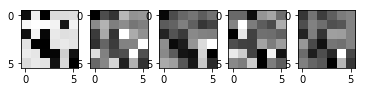

In [3980]:
K = max(glm.get_current_K(),2)
fig, ax = plt.subplots(1,K)
for i in range(K):
    ax[i].imshow((glm.A[i]).view(6,6).detach(), cmap= 'gray')
plt.show()

In [3960]:
glm.temperature

0.5

In [3917]:
glm.aeys

Parameter containing:
tensor([[ 9.0185, 10.2534, 10.3426,  7.8936,  5.0514,  2.3895]],
       requires_grad=True)

In [3918]:
glm.bees

Parameter containing:
tensor([[0.6312, 1.1270, 2.2884, 2.1963, 1.6916, 2.3971]], requires_grad=True)

In [3919]:
glm.rhos

tensor([[1.0000],
        [0.8880],
        [0.7461],
        [0.6350],
        [0.3880],
        [0.5279],
        [0.9955]], grad_fn=<CopySlices>)

In [3728]:
train_data.max()

0.9999183555414849

In [3692]:
rrs_loss(glm, images, 2)

tensor(-171.8081, grad_fn=<SubBackward0>) tensor(229.1926, grad_fn=<SumBackward0>) tensor(-691.1736, grad_fn=<SumBackward0>)
tensor(-197.3585, grad_fn=<SubBackward0>) tensor(236.7233, grad_fn=<SumBackward0>) tensor(-709.1802, grad_fn=<SumBackward0>)


RuntimeError: shape '[2, 1]' is invalid for input of size 3

In [3920]:
for i in range(100):
    x, z , zi , pi = glm(images,3)
    val = (x != x).sum()
    print(val)
    clr(wait= True)
    if(val>0):
        break

tensor(0)


In [3881]:
pi[11,:]

tensor([[0.4982, 0.3326, 0.4764, 0.7702, 0.7935, 0.3854, 0.1455, 0.2480, 0.5870,
         0.3403, 0.7274, 0.1689, 0.1658, 0.3739, 0.4096, 0.5540, 0.3415, 0.7012,
         0.3872, 0.3666],
        [0.4010, 0.1600, 0.1701, 0.4697, 0.3739, 0.0537,    nan, 0.1024, 0.1783,
         0.1664, 0.0337, 0.1262, 0.0352, 0.2699, 0.1727, 0.1628, 0.1440, 0.3571,
         0.0842, 0.1659],
        [0.2589, 0.0623, 0.0345, 0.2622, 0.1843, 0.0309,    nan, 0.0846, 0.0232,
         0.0427, 0.0160, 0.0717, 0.0255, 0.1978, 0.0687, 0.0720, 0.0946, 0.1493,
         0.0800, 0.1114]], grad_fn=<SliceBackward>)

In [3882]:
pi[83,1,:]

tensor([0.1599, 0.3681, 0.1899, 0.4187, 0.5601, 0.1870, 0.1079, 0.2163, 0.3314,
        0.2703, 0.4668, 0.2703, 0.0325, 0.0561, 0.3350, 0.0725, 0.3242, 0.4107,
        0.1942, 0.2119], grad_fn=<SliceBackward>)

In [3883]:
glm.aeys

Parameter containing:
tensor([[2.4431, 3.1653, 2.8721, 2.7525]], requires_grad=True)

In [3884]:
glm.bees

Parameter containing:
tensor([[1.7972, 1.8713, 2.2071, 2.6576]], requires_grad=True)